<a href="https://colab.research.google.com/github/jmestanza/computer-vision-2/blob/main/tp_vpc2_yolo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabajo práctico integrador de Visión por Computadora 2
Autor: Joaquín Mestanza

N° SIU: a1726

## Problema a resolver

Detección de vehículos con imágenes en plano cenital

## Contexto y restricciones

Las imágenes son tomadas por un drone desde un plano cenital.

Las imágenes son RGB y son de alta resolución (3024x4032 pixeles, height x width).

No siempre hay vehículos ni personas en las instalaciones, de hecho es algo poco frecuente.

## Datasets candidatos

- [Dataset 1] https://universe.roboflow.com/wictronix-ubfrb/atlanz_wx-wthzi

- [Dataset 2] https://universe.roboflow.com/sardar-vallabhbhai-national-institute-if-technology/vehicle-detection-wagr7

- [Dataset 3] https://universe.roboflow.com/roy15957-gmail-com/object-detection-from-drone

Se tuvo en cuenta como primer filtro para la elección de datasets, que tengan al menos 1000 imágenes.
Los 3 dataset incluyen detección de autos, pero el tercero incluye personas también.

## Proceso

Antes de entrenar, debemos tener en cuenta con qué vamos a evaluar.
De ahí salen las siguientes preguntas:

### Entrenamiento
- Vamos a entrenar (train+validation) con
  - Los datasets de roboflow? (3.7k y 1.5k imágenes etiquetadas)

  o
  - Un dataset armado por nosotros? (que implica un etiquetado previo... 1000 imágenes al menos?)
### Testing
- Vamos a evaluar con (test)
  - Los datasets de roboflow? (al menos 100 imágenes)

  y / o
  - Un dataset armado por nosotros? (implica un subset etiquetado, al menos de 100 imágenes)

Algo a tener en cuenta es que cuando probemos con las imágenes en las inspecciones, el terreno es bastante distinto al de las imágenes de roboflow, por lo cual es posible que haya un decaimiento en la performance.
### Métricas a utilizar

La métrica a utilizar es la mAP (mean average precision).

Esta métrica depende de:
- La confianza p de que existe un objeto sea mayor a cierto umbral (> 80%, por ejemplo).
- Que la clase predicha sea la correcta
- Que la IoU del bounding box predicho y el ground truth sea mayor a un umbral predicho (> 50%, por ejemplo).

Hay que tener en consideración que al modificar los valores umbrales de IoU y confianza, cambia nuestra definición de TP (True Positive), FN (False negative), FP (False positive) y TN (True Negative), dando posibles mejores resultados de los que realmente presenta nuestro modelo.


## Utilidades

Query para obtener las imágenes en plano cenital:
```sql
SELECT
	*
FROM
	IMAGE
WHERE
	"missionId" = 'mission_uuid'
	AND (DATA -> 'metadata' -> 'gimbal' ->> 'pitch')::NUMERIC > -(90+10) -- (-90) grados +/- 10
	AND (DATA -> 'metadata' -> 'gimbal' ->> 'pitch')::NUMERIC < -(90-10)
ORDER BY
	CREATED_AT DESC
LIMIT
	100;
```

In [1]:
# !pip install torch torchvision torchaudio
# !pip install 'git+https://github.com/facebookresearch/detectron2.git'
!pip install ultralytics


Generamos un token para poder subir la info de las runs a Github.

In [2]:
import os
from getpass import getpass
if not os.path.exists('github_pat.txt'):
  github_pat = getpass()
  with open('github_pat.txt', 'w+') as f:
    f.write(github_pat)
else:
  with open('github_pat.txt', 'r') as f:
    github_pat = f.read()

## Descarga de dataset

In [83]:
import os
if not os.path.exists('dataset'):
  !curl -L "https://universe.roboflow.com/ds/oXYyTH2btN?key=NM3Z7u9aVZ" > roboflow.zip; echo "Unzipping..."; mkdir dataset; unzip -q roboflow.zip -d dataset; rm roboflow.zip; echo "Completed successfully."

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   903  100   903    0     0   1790      0 --:--:-- --:--:-- --:--:--  1791
100  423M  100  423M    0     0  15.5M      0  0:00:27  0:00:27 --:--:-- 17.8M
Unzipping...
Completed successfully.


In [27]:
!cat /content/dataset/data.yaml

train: ../train/images
val: ../valid/images
test: ../test/images

nc: 14
names: ['bu5', 'c4r', 'consV3h', 'motorbik3', 'p3rson', 'tr2ck', 'tr4ck', 'v3hicle', 'vai', 'vai_false', 'vai_true', 'vap', 'vap_false', 'vap_true']

roboflow:
  workspace: roy15957-gmail-com
  project: object-detection-from-drone
  version: 2
  license: Private
  url: https://universe.roboflow.com/roy15957-gmail-com/object-detection-from-drone/dataset/2

In [32]:
new_yaml="""train: /content/dataset/train/images
val: /content/dataset/valid/images

nc: 14
names: ['bu5', 'c4r', 'consV3h', 'motorbik3', 'p3rson', 'tr2ck', 'tr4ck', 'v3hicle', 'vai', 'vai_false', 'vai_true', 'vap', 'vap_false', 'vap_true']
"""
with open("dataset/new_data.yaml", "w") as f:
  f.write(new_yaml)

In [35]:
!cat /content/dataset/new_data.yaml

train: /content/dataset/train/images
val: /content/dataset/valid/images

nc: 14
names: ['bu5', 'c4r', 'consV3h', 'motorbik3', 'p3rson', 'tr2ck', 'tr4ck', 'v3hicle', 'vai', 'vai_false', 'vai_true', 'vap', 'vap_false', 'vap_true']


In [36]:
import os
from pathlib import Path

# --- config ---
dataset_root = Path("/content/dataset")
splits = ["train", "valid"]

# original class names in order (same as in new_data.yaml)
original_names = ['bu5', 'c4r', 'consV3h', 'motorbik3', 'p3rson', 'tr2ck', 'tr4ck', 'v3hicle', 'vai', 'vai_false', 'vai_true', 'vap', 'vap_false', 'vap_true']

# keyword groups
person_keywords = {"p3rson"}
vehicle_keywords = {"bu5", "c4r", "consV3h", "motorbik3", "tr2ck", "tr4ck", "v3hicle"}

# Create mapping from original class index to new class index or None (to ignore)
remap_dict = {}
for idx, name in enumerate(original_names):
    if name in person_keywords:
        remap_dict[idx] = 0  # person
    elif name in vehicle_keywords:
        remap_dict[idx] = 1  # vehicle
    else:
        remap_dict[idx] = None  # ignore

# --- process each label file ---
for split in splits:
    label_dir = dataset_root / split / "labels"
    for label_path in label_dir.glob("*.txt"):
        new_lines = []
        with open(label_path, "r") as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) != 5:
                    continue  # skip malformed lines
                class_id = int(parts[0])
                new_class = remap_dict.get(class_id)
                if new_class is not None:
                    new_line = f"{new_class} {' '.join(parts[1:])}"
                    new_lines.append(new_line)
        # Overwrite with filtered and remapped labels
        with open(label_path, "w") as f:
            f.write("\n".join(new_lines) + "\n" if new_lines else "")


In [37]:
new_yaml="""train: /content/dataset/train/images
val: /content/dataset/valid/images

nc: 2
names: ['person', 'vehicle']
"""
with open("dataset/new_data.yaml", "w") as f:
  f.write(new_yaml)

Showing images for class: person


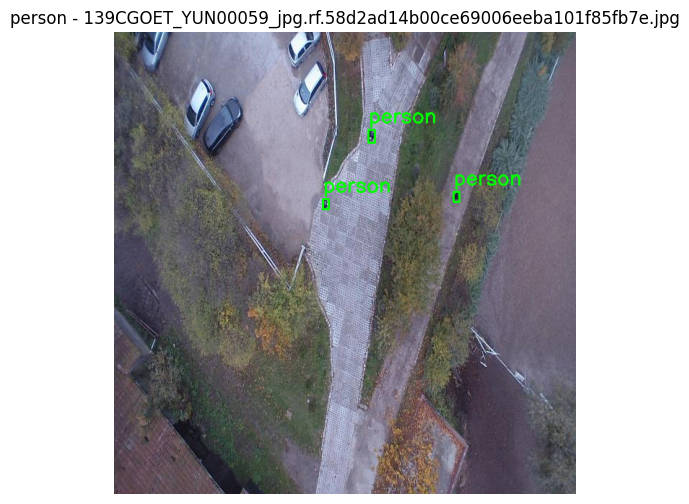

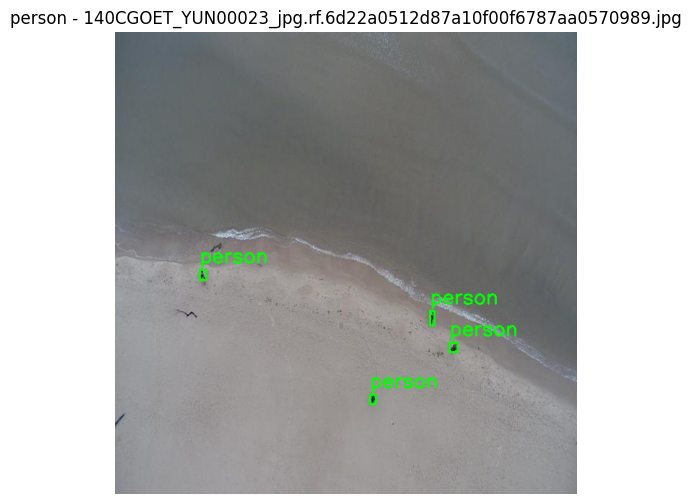

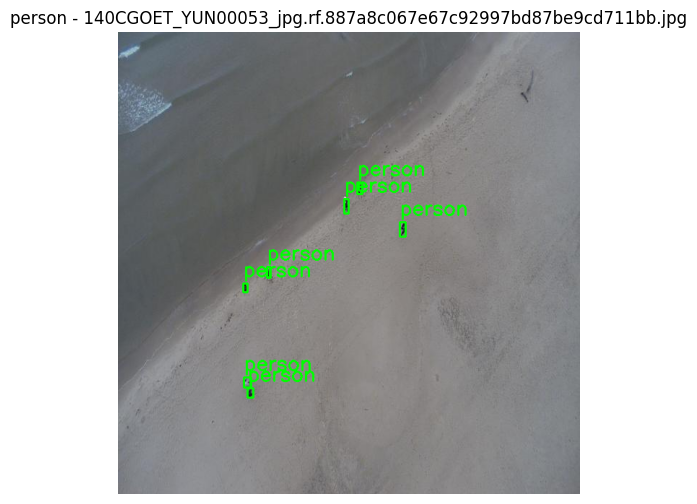

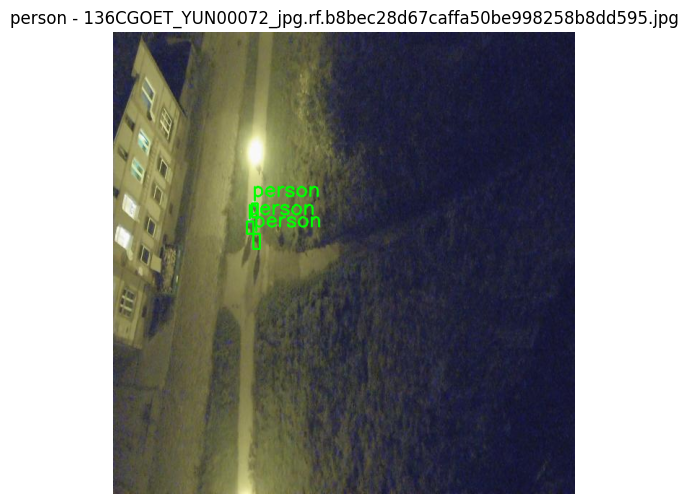

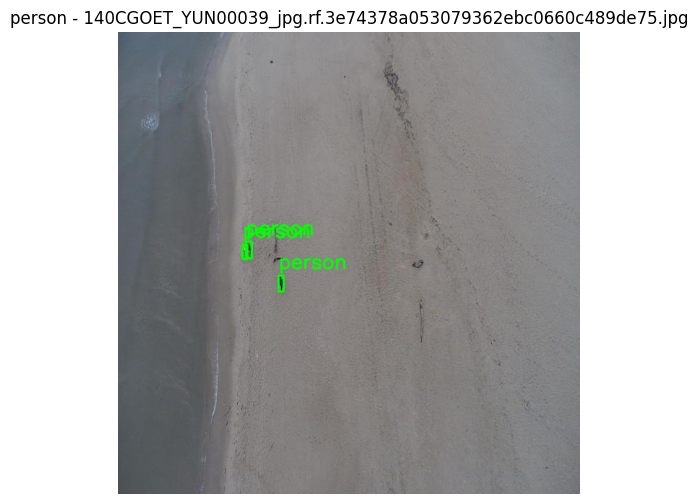

Showing images for class: vehicle


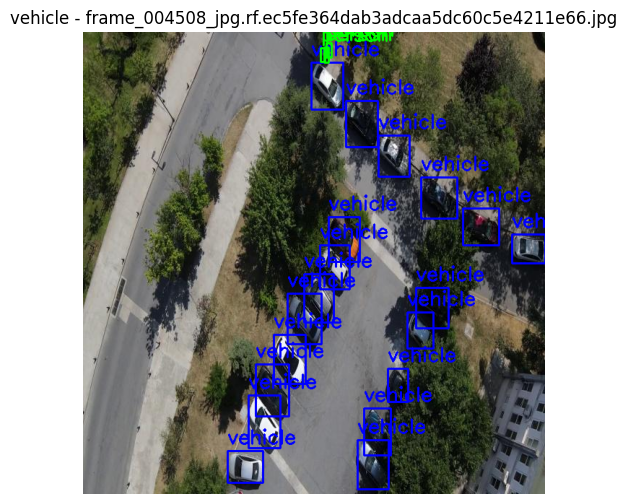

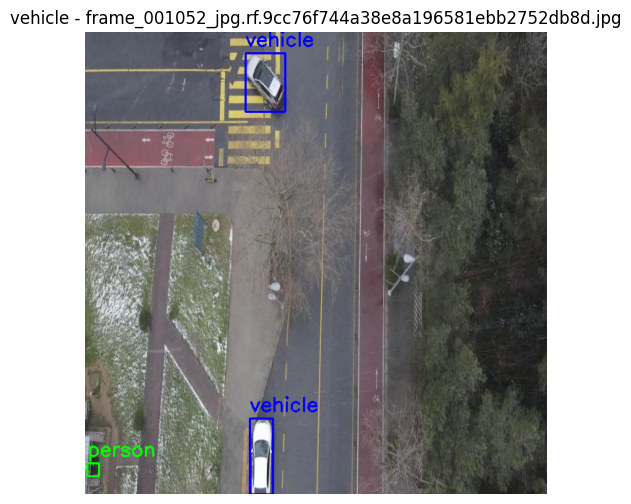

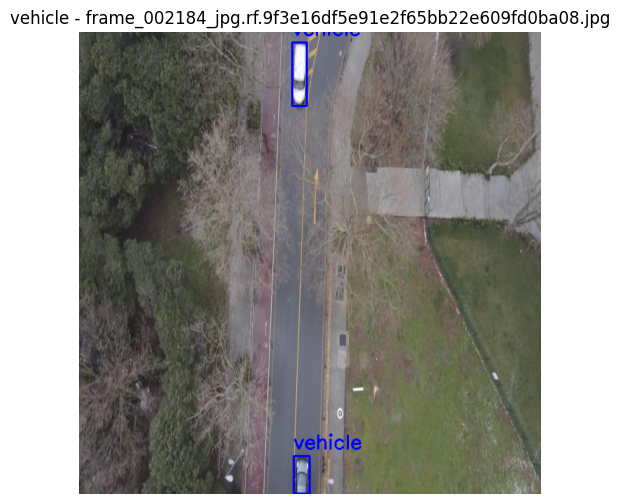

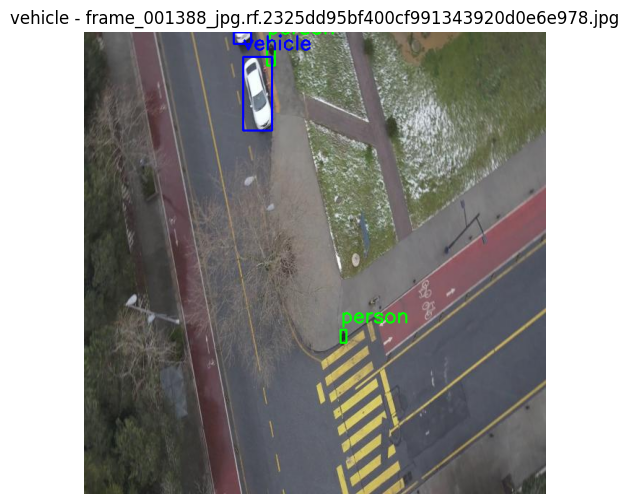

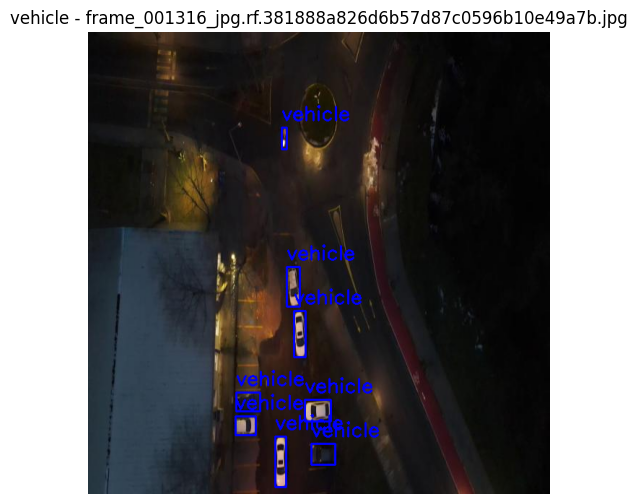

In [39]:
import cv2
import matplotlib.pyplot as plt
from pathlib import Path
from collections import defaultdict

# --- Setup ---
data_root = Path("/content/dataset/valid")
image_dir = data_root / "images"
label_dir = data_root / "labels"
class_names = ['person', 'vehicle']
images_per_class = 5

# --- Collect images with at least one object of each class ---
class_to_images = defaultdict(list)

for label_path in label_dir.glob("*.txt"):
    with open(label_path) as f:
        lines = f.readlines()
        found_classes = set(int(line.split()[0]) for line in lines if line.strip())
    for cls in found_classes:
        if cls in [0, 1] and len(class_to_images[cls]) < images_per_class:
            class_to_images[cls].append(label_path.stem)

# --- Visualization ---
for cls_id, image_names in class_to_images.items():
    print(f"Showing images for class: {class_names[cls_id]}")
    for name in image_names:
        image_path = image_dir / f"{name}.jpg"
        label_path = label_dir / f"{name}.txt"
        if not image_path.exists() or not label_path.exists():
            continue

        # Load image
        img = cv2.imread(str(image_path))
        h, w = img.shape[:2]

        # Draw bounding boxes
        with open(label_path) as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) != 5:
                    continue
                class_id, x, y, bw, bh = map(float, parts)
                class_id = int(class_id)
                cx, cy, bw, bh = x * w, y * h, bw * w, bh * h
                x1, y1 = int(cx - bw / 2), int(cy - bh / 2)
                x2, y2 = int(cx + bw / 2), int(cy + bh / 2)
                color = (0, 255, 0) if class_id == 0 else (255, 0, 0)
                cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
                cv2.putText(img, class_names[class_id], (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)

        # Display
        plt.figure(figsize=(8, 6))
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title(f"{class_names[cls_id]} - {image_path.name}")
        plt.show()


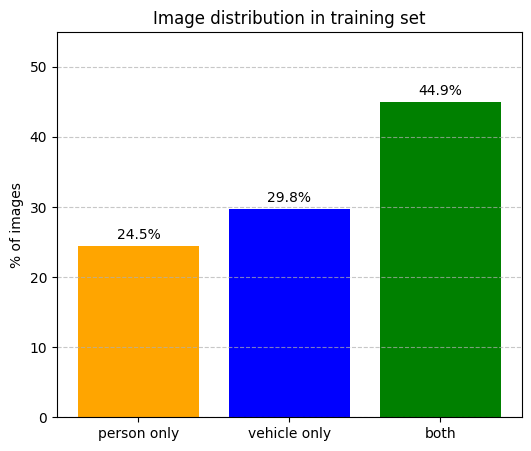

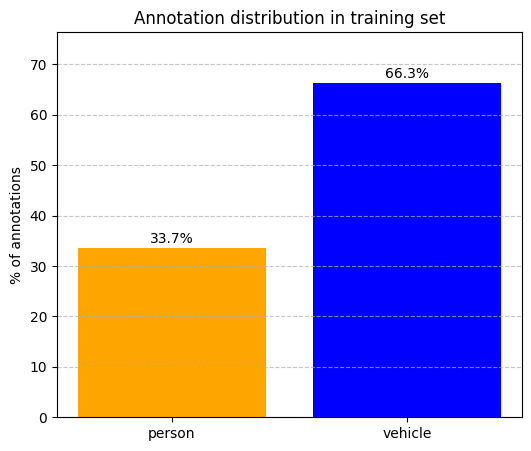

In [40]:
import matplotlib.pyplot as plt
from pathlib import Path
from collections import defaultdict

label_dir = Path("/content/dataset/train/labels")
image_count = {'person': 0, 'vehicle': 0, 'both': 0}
annotation_count = {'person': 0, 'vehicle': 0}
total_images = 0

for label_file in label_dir.glob("*.txt"):
    with open(label_file) as f:
        lines = [line.strip() for line in f if line.strip()]
    total_images += 1
    has_person = False
    has_vehicle = False

    for line in lines:
        class_id = int(line.split()[0])
        if class_id == 0:
            has_person = True
            annotation_count['person'] += 1
        elif class_id == 1:
            has_vehicle = True
            annotation_count['vehicle'] += 1

    if has_person and has_vehicle:
        image_count['both'] += 1
    elif has_person:
        image_count['person'] += 1
    elif has_vehicle:
        image_count['vehicle'] += 1

# --- Plot image-level distribution ---
img_labels = ['person only', 'vehicle only', 'both']
img_values = [
    image_count['person'],
    image_count['vehicle'],
    image_count['both']
]
img_percentages = [v / total_images * 100 for v in img_values]

plt.figure(figsize=(6, 5))
plt.bar(img_labels, img_percentages, color=['orange', 'blue', 'green'])
plt.ylabel('% of images')
plt.title('Image distribution in training set')
for i, v in enumerate(img_percentages):
    plt.text(i, v + 1, f"{v:.1f}%", ha='center')
plt.ylim(0, max(img_percentages) + 10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# --- Plot annotation-level distribution ---
ann_labels = ['person', 'vehicle']
ann_values = [annotation_count['person'], annotation_count['vehicle']]
ann_total = sum(ann_values)
ann_percentages = [v / ann_total * 100 for v in ann_values]

plt.figure(figsize=(6, 5))
plt.bar(ann_labels, ann_percentages, color=['orange', 'blue'])
plt.ylabel('% of annotations')
plt.title('Annotation distribution in training set')
for i, v in enumerate(ann_percentages):
    plt.text(i, v + 1, f"{v:.1f}%", ha='center')
plt.ylim(0, max(ann_percentages) + 10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


## Imágenes donde no hay ni vehículos ni personas

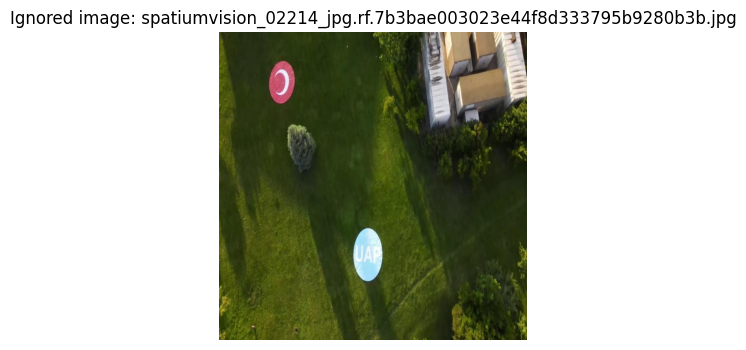

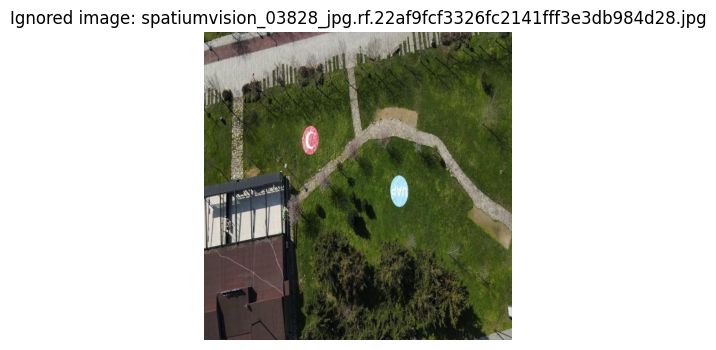

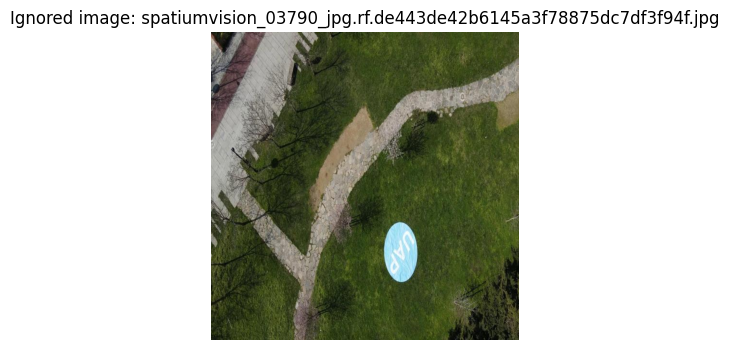

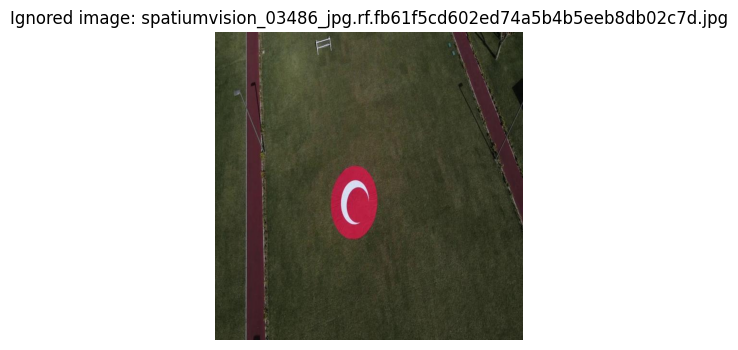

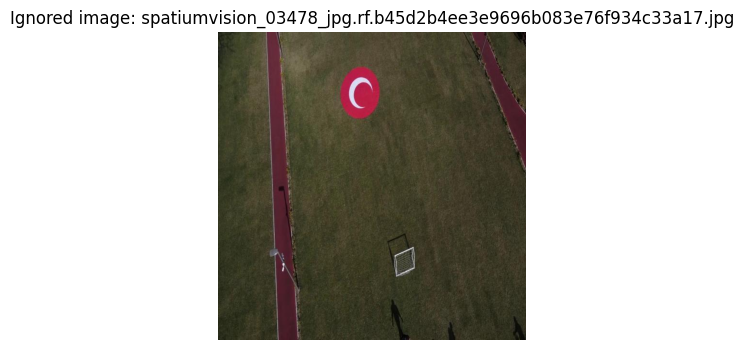

In [41]:
import cv2
import matplotlib.pyplot as plt
from pathlib import Path

image_dir = Path("/content/dataset/train/images")
label_dir = Path("/content/dataset/train/labels")

ignored_images = []

for label_path in label_dir.glob("*.txt"):
    with open(label_path) as f:
        lines = [line.strip() for line in f if line.strip()]

    only_ignored = all(int(line.split()[0]) not in (0, 1) for line in lines) if lines else True

    if only_ignored:
        img_path = image_dir / f"{label_path.stem}.jpg"
        if img_path.exists():
            ignored_images.append(img_path)
        if len(ignored_images) >= 5:
            break

# --- Show images ---
for img_path in ignored_images:
    img = cv2.imread(str(img_path))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(6, 4))
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.title(f"Ignored image: {img_path.name}")
    plt.show()


In [43]:
import os

repo_path = '/content/computer-vision-2'
if not os.path.exists(repo_path):
  print('Repo not downloaded yet.')
  !git clone https://{github_pat}@github.com/jmestanza/computer-vision-2.git
else:
  print('Repo available.')

Repo available.


In [44]:
import datetime
import uuid

if not os.path.exists(f'{repo_path}/runs'):
    os.makedirs(f'{repo_path}/runs')
    print('Directory created.')
else:
    print('Directory already exists.')

run_id = str(uuid.uuid4())
print("run_id: ", run_id)
run_id_folder = f"run_id_{run_id}"

if not os.path.exists(f'{repo_path}/runs/{run_id_folder}'):
    os.makedirs(f'{repo_path}/runs/{run_id_folder}')
    print('Directory created.')
else:
    print('Directory already exists.')

Directory already exists.
run_id:  865ab82b-48ee-4b3d-9428-af8b494338b4
Directory created.


In [45]:
from ultralytics import YOLO
import os
import json
import os

cache_dir = "/content/dataset"
for cache_file in ["train.cache", "valid.cache"]:
    cache_path = os.path.join(cache_dir, cache_file)
    if os.path.exists(cache_path):
        os.remove(cache_path)
        print(f"Deleted {cache_path}")

In [ ]:
# Pick model type: 'yolov8n', 'yolov8s', 'yolov8m', 'yolov8l', 'yolov8x'
model = YOLO('yolov8s.yaml')  # You can also use 'yolov8s.pt' for pretrained weights

# Optional: use pretrained weights
# model = YOLO('yolov8s.pt')

# Start training
model.train(
    data='/content/dataset/new_data.yaml',         # path to your YAML
    epochs=100,                      # or more if needed
    imgsz=640,                       # image size
    batch=16,
    name='yolo_person_vehicle',      # experiment name
    project='./runs',
    device=0,                        # set to 'cpu' or specific GPU ID
    workers=2,
    optimizer='SGD',                 # or 'Adam'
    lr0=0.001,
    warmup_epochs=3,
    cos_lr=True,
    weight_decay=0.0005,
    patience=20,                     # early stopping
    val=True                         # evaluate on val set
)

Ultralytics 8.3.112 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.yaml, data=/content/dataset/new_data.yaml, epochs=100, time=None, patience=20, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=2, project=./runs, name=yolo_person_vehicle9, exist_ok=False, pretrained=True, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes

100%|██████████| 5.35M/5.35M [00:00<00:00, 330MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1771.6±738.6 MB/s, size: 75.0 KB)


train: Scanning /content/dataset/train/labels... 5175 images, 43 backgrounds, 0 corrupt: 100%|██████████| 5175/5175 [00:02<00:00, 2199.21it/s]


train: New cache created: /content/dataset/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.1 ms, read: 878.9±573.9 MB/s, size: 53.7 KB)


val: Scanning /content/dataset/valid/labels... 1248 images, 16 backgrounds, 0 corrupt: 100%|██████████| 1248/1248 [00:01<00:00, 1022.09it/s]

val: New cache created: /content/dataset/valid/labels.cache


Plotting labels to runs/yolo_person_vehicle9/labels.jpg... 
optimizer: SGD(lr=0.001, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/yolo_person_vehicle9
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      4.32G      5.564      4.907      4.173        380        640:  13%|█▎        | 43/324 [00:15<01:28,  3.18it/s]

In [ ]:
# metrics are under output folder
!cp -r output/ {repo_path}/runs/{run_id_folder}
# delete pth as it weights too much (300Mb)
!rm -rf {repo_path}/runs/{run_id_folder}/output/*.pth

with open(f'{repo_path}/runs/{run_id_folder}/cfg-{run_id}.yaml', "w") as f:
    f.write(cfg.dump())

In [ ]:
start_path = os.getcwd()
print(start_path)
os.chdir(repo_path)
print(os.getcwd())
!git config --global user.email "jmestanza@gmail.com"
!git config --global user.name "jmestanza"
!git config pull.rebase false
!git pull
!git add .
# !git commit -m "uploading run {run_id}"
os.system(f'git commit -m "uploading run {run_id}"')
!git push origin main
os.chdir(start_path)

In [ ]:
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.data.transforms import AugInput
import matplotlib.pyplot as plt
import cv2
from detectron2.data import transforms as T
import detectron2.data.detection_utils as utils

augmentations = [
    T.RandomFlip(prob=0.5, horizontal=True, vertical=False),
    T.RandomBrightness(0.8, 1.2),
    T.RandomContrast(0.8, 1.2),
    T.RandomSaturation(0.8, 1.2),
    # You can also add:
    T.RandomRotation(angle=[-10, 10]),
    T.RandomCrop("relative_range", (0.8, 0.8)),
]

dataset_dicts = DatasetCatalog.get(train_dataset_name)
metadata = MetadataCatalog.get(train_dataset_name)
sample = dataset_dicts[0]
image = utils.read_image(sample["file_name"], format="BGR")
auginput = AugInput(image)
transform = T.AugmentationList(augmentations)(auginput)
aug_image = auginput.image

plt.imshow(cv2.cvtColor(aug_image, cv2.COLOR_BGR2RGB))
plt.title("Augmented Image")
plt.axis("off")
plt.show()


In [ ]:
import random
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
import matplotlib.pyplot as plt
import cv2
import os

def predict_n_random_images(n=5):
  # Initialize predictor

  # Point to your trained model
  cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, f"model_final.pth")
  # cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_0024999.pth")

  # Recreate the predictor after setting weights
  predictor = DefaultPredictor(cfg)

  # Get metadata
  metadata = MetadataCatalog.get(val_dataset_name)

  # Shuffle images
  val_images = sorted(os.listdir(val_path))
  random.shuffle(val_images)

  # Show n random predictions
  num_to_show = n
  for i, fname in enumerate(val_images[:num_to_show]):
      image_path = os.path.join(val_path, fname)
      image = cv2.imread(image_path)

      outputs = predictor(image)
      instances = outputs["instances"].to("cpu")

      v = Visualizer(image[:, :, ::-1], metadata=metadata, scale=1.0)
      out = v.draw_instance_predictions(instances)

      plt.figure(figsize=(10, 10))
      plt.imshow(out.get_image())
      plt.title(f"Predictions for: {fname}")
      plt.axis("off")
      plt.show()

predict_n_random_images(5)

## Descargo pesos automáticamente

In [ ]:
print(eval_period)

In [ ]:
weights = [el for el in os.listdir('output') if el.startswith('model') and el.endswith('.pth')]
print(weights)
# download 5 last weights

In [ ]:
from google.colab import files
# save best models
output_dir = cfg.OUTPUT_DIR

best_model_person = f"model_best_person_{run_id}.pth"
best_model_vehicle = f"model_best_vehicle_{run_id}.pth"
files.download(f"{output_dir}/{best_model_person}")
files.download(f"{output_dir}/{best_model_vehicle}")

In [ ]:
# save last
import shutil
new_filename = f"model_final_{run_id}.pth"
shutil.copy(f"{output_dir}/model_final.pth", f"{output_dir}/{new_filename}")
files.download(f"{output_dir}/{new_filename}")

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir output

In [ ]:
%tensorboard --logdir {repo_path}/runs